In [ ]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import random
import os

In [2]:
folder_name = '/u/student/2024/cs24btnsr11002/2.0' ## replace with your local path for mimiciv-2.0 data
save_folder_name = '/u/student/2024/cs24btnsr11002/2.0/saved_dataset' ## replace with your local path for saving files during preprocessing

if not os.path.exists(save_folder_name):
    os.makedirs(save_folder_name)
pd.set_option('display.max_columns', None)

In [3]:
folder_name = '/u/student/2024/cs24btnsr11002/2.0' ## replace with your local path for mimiciv-2.0 data
save_folder_name = '/u/student/2024/cs24btnsr11002/2.0/saved_dataset' ## replace with your local path for saving files during preprocessing
if not os.path.exists(save_folder_name):
    os.makedirs(save_folder_name)

# load patients, make patient dictionary.
patients = pd.read_csv(folder_name + '/patients.csv.gz')
patients_dict = {}
for row in patients.values:
    patients_dict[row[0]] = [row[1], row[2], row[3], row[4], row[5]]  # gender, anchor_age, anchor_year, anchor_year_group, dod

# load admission
admissions = pd.read_csv(folder_name + '/admissions.csv.gz')
patients_anchor_age_not_last_v_y = {}
tmp = admissions.groupby(['subject_id'])

for key, item in tmp:
    key = key[0]
    group_df = tmp.get_group(key)
    group_df = group_df.reset_index(drop=True)
    discharge_time_list = [datetime.strptime(str_time, "%Y-%m-%d %H:%M:%S") for str_time in list(group_df['dischtime'])]
    last_discharge_timestr = sorted(discharge_time_list, key=lambda t: t, reverse=True)[0].strftime("%Y-%m-%d %H:%M:%S")
    last_admission_row_id = list(group_df['dischtime'] == last_discharge_timestr).index(1)
    if key in patients_dict.keys():
        patients_dict[key] = patients_dict[key] + [group_df.iloc[last_admission_row_id]['race'], group_df.iloc[last_admission_row_id]['hadm_id'], group_df.iloc[last_admission_row_id]['admittime'], group_df.iloc[last_admission_row_id]['dischtime'], group_df.iloc[last_admission_row_id]['deathtime'], group_df.iloc[last_admission_row_id]['admission_type'], group_df.iloc[last_admission_row_id]['insurance'], group_df.iloc[last_admission_row_id]['admission_location'], group_df.iloc[last_admission_row_id]['discharge_location']]
    if patients_dict[key][2] != int(patients_dict[key][7][:4]):
        patients_anchor_age_not_last_v_y[key] = [patients_dict[key][1], patients_dict[key][2], patients_dict[key][7]]

patients_dict_w_admission = {}
patients_dict_w_admission_n_die_inhosp = {}
one_y_outcome = {}
die_count = 0
for key, ele in patients_dict.items():
    if len(ele) > 5:
        patients_dict_w_admission[key] = ele
        if ele[9] != ele[9]: # patients not die in hospital
            patients_dict_w_admission_n_die_inhosp[key] = ele
            if ele[4] == ele[4]:
                one_y_outcome[key] = 1  # die in one year after last hospital stay
                die_count += 1
            else:
                one_y_outcome[key] = 0  # not die in one year after last hospital stay

print("Num of patients in total: %d" % len(patients_dict))        
print("Num of patients with admissions: %d" % len(patients_dict_w_admission))
print("Num of patients with admissions and not die in hospital: %d" % len(patients_dict_w_admission_n_die_inhosp))
print("    among which, %d (%.2f) patients died in one year after their last admission." % (die_count, die_count/len(patients_dict_w_admission_n_die_inhosp))) 


np.save(save_folder_name + '/patients_dict_w_admission.npy', patients_dict_w_admission) # All patients who are admitted 
np.save(save_folder_name + '/patients_anchor_age_not_last_v_y.npy', patients_anchor_age_not_last_v_y) # Patients anchor_year does not matches with admission year.
np.save(save_folder_name + '/patients_dict_w_admission_n_die_inhosp.npy', patients_dict_w_admission_n_die_inhosp)  # Patients who not died in hospital.
np.save(save_folder_name + '/one_y_outcome.npy', one_y_outcome) # patient died in one year after last visit to hospital 0 & 1

/tmp/ipykernel_3681022/782843289.py:19: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


Num of patients in total: 364627
Num of patients with admissions: 223452
Num of patients with admissions and not die in hospital: 211675
    among which, 25105 (0.12) patients died in one year after their last admission.


In [4]:
# load diagnoses. note that this could take ~3h to run.
diagnoses = pd.read_csv(folder_name + '/diagnoses_icd.csv.gz')
diagnoses_pt_df = pd.DataFrame()
tmp = diagnoses.groupby(['subject_id'])

for key, item in tmp:
    key = key[0]
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        diagnoses_pt_df = pd.concat([diagnoses_pt_df, group_df], ignore_index=True)

diagnoses_pt_df.to_csv(folder_name + '/diagnoses_selected_cohort.csv', index=False)

# diagnoses_pt_df = pd.read_csv(folder_name + '/diagnoses_selected_cohort.csv')

patient_diagnosis_dict = {}
patients_w_icd_9_10 = []
temp = diagnoses_pt_df.groupby(['subject_id', 'icd_version'])
for key, item in temp:
    if key[0] not in patient_diagnosis_dict.keys():
        patient_diagnosis_dict[key[0]] = {'icd9':[], 'icd10':[]}
    if key[1] == 9:
        patient_diagnosis_dict[key[0]]['icd9'] = list(set(item['icd_code']))
    else:
        patient_diagnosis_dict[key[0]]['icd10'] = list(set(item['icd_code']))
    
    if len(patient_diagnosis_dict[key[0]]['icd9']) > 0 and len(patient_diagnosis_dict[key[0]]['icd10']) > 0:
        patients_w_icd_9_10.append(key[0])

np.save(save_folder_name + '/patient_diagnosis_dict.npy', patient_diagnosis_dict)
np.save(save_folder_name + '/patients_w_icd_diag_9_10.npy', patients_w_icd_9_10)

/tmp/ipykernel_3226710/2776046188.py:9: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


In [5]:
first_5_patients = list(patient_diagnosis_dict.keys())[:5]

# Print their diagnoses
for patient in first_5_patients:
    print(f"Patient ID: {patient}")
    print(f"ICD-9 Codes: {patient_diagnosis_dict[patient]['icd9']}")
    print(f"ICD-10 Codes: {patient_diagnosis_dict[patient]['icd10']}")
    print("-" * 50)

Patient ID: 10000032
ICD-9 Codes: ['78791', '3051', '45829', '2875', 'V08', 'V462', 'V4986', '496', '78959', '5723', '07054', '30981', '07044', '5715', '7994', '2767', 'V1582', '07071', '07070', '29680', '2761']
ICD-10 Codes: []
--------------------------------------------------
Patient ID: 10000068
ICD-9 Codes: ['30500']
ICD-10 Codes: []
--------------------------------------------------
Patient ID: 10000084
ICD-9 Codes: []
ICD-10 Codes: ['R609', 'G3183', 'F0280', 'R4182', 'G20', 'E785', 'Z8546', 'R441', 'R296']
--------------------------------------------------
Patient ID: 10000108
ICD-9 Codes: ['5283', '52109']
ICD-10 Codes: []
--------------------------------------------------
Patient ID: 10000117
ICD-9 Codes: []
ICD-10 Codes: ['Z87442', 'F419', 'M810', 'G43909', 'R0989', 'Z7901', 'W010XXA', 'S72012A', 'K31819', 'E7800', 'Y92480', 'K449', 'I341', 'Y93K1', 'K219', 'R1310', 'Z87891']
--------------------------------------------------


In [6]:
# load procedure hcpcs
procedures_hcpcs = pd.read_csv(folder_name + '/hcpcsevents.csv.gz')
procedures_hcpcs.head()

,subject_id,hadm_id,chartdate,hcpcs_cd,seq_num,short_description
0,10000068,25022803,2160-03-04,99218,1,Hospital observation services
1,10000084,29888819,2160-12-28,G0378,1,Hospital observation per hr
2,10000108,27250926,2163-09-27,99219,1,Hospital observation services
3,10000117,22927623,2181-11-15,43239,1,Digestive system
4,10000117,22927623,2181-11-15,G0378,2,Hospital observation per hr


In [7]:
procedures_hcpcs = pd.read_csv(folder_name + '/hcpcsevents.csv.gz')
procedures_hcpcs_pt_df = pd.DataFrame()
tmp = procedures_hcpcs.groupby(['subject_id'])
for key, item in tmp:
    key = key[0]
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        procedures_hcpcs_pt_df = pd.concat([procedures_hcpcs_pt_df,group_df], ignore_index=True)
# load procedure hcpcs

# procedures_hcpcs_pt_df.to_csv(folder_name + '/procedures_hcpcs_selected_cohort.csv', index=False)

patient_procedures_hcpcs_dict = {}
temp = procedures_hcpcs_pt_df.groupby(['subject_id'])
for key, item in temp:
    key = key[0]
    hcpcs_list = list(item['hcpcs_cd'])
    cpt_list = []
    for code in hcpcs_list:
        if not any(c.isalpha() for c in code):
            cpt_list.append(code)
    patient_procedures_hcpcs_dict[key] = list(set(cpt_list))

np.save(save_folder_name + '/patient_procedures_hcpcs_dict.npy', patient_procedures_hcpcs_dict)

/tmp/ipykernel_3226710/4278982303.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


In [8]:
procedures_hcpcs_pt_df.head()  #Hcpcs events of patients who are not die in hospital

,subject_id,hadm_id,chartdate,hcpcs_cd,seq_num,short_description
0,10000068,25022803,2160-03-04,99218,1,Hospital observation services
1,10000084,29888819,2160-12-28,G0378,1,Hospital observation per hr
2,10000108,27250926,2163-09-27,99219,1,Hospital observation services
3,10000117,22927623,2181-11-15,43239,1,Digestive system
4,10000117,22927623,2181-11-15,G0378,2,Hospital observation per hr


In [9]:
for i, (key, value) in enumerate(patient_procedures_hcpcs_dict.items()):
    if i == 5:  # Stop after printing 5 entries
        break
    print(f"Patient ID: {key}, Procedures: {value}")

Patient ID: 10000068, Procedures: ['99218']
Patient ID: 10000084, Procedures: []
Patient ID: 10000108, Procedures: ['99219']
Patient ID: 10000117, Procedures: ['43239']
Patient ID: 10000161, Procedures: ['99219']


In [7]:
# load procedure icd
procedures_icd = pd.read_csv(folder_name + '/procedures_icd.csv.gz')
procedures_icd_pt_df = pd.DataFrame()
tmp = procedures_icd.groupby(['subject_id'])

for key, item in tmp:
    key = key[0]
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        procedures_icd_pt_df = pd.concat([procedures_icd_pt_df, group_df], ignore_index=True)
procedures_icd_pt_df.to_csv(folder_name + '/procedures_icd_selected_cohort.csv', index=False)

patient_procedures_icd_dict = {}
patients_w_icd_9_10 = []
temp = procedures_icd_pt_df.groupby(['subject_id', 'icd_version'])
for key, item in temp:
    if key[0] not in patient_procedures_icd_dict.keys():
        patient_procedures_icd_dict[key[0]] = {'icd9':[], 'icd10':[]}
    if key[1] == 9:
        patient_procedures_icd_dict[key[0]]['icd9'] = list(set(item['icd_code']))
    else:
        patient_procedures_icd_dict[key[0]]['icd10'] = list(set(item['icd_code']))
    
    if len(patient_procedures_icd_dict[key[0]]['icd9']) > 0 and len(patient_procedures_icd_dict[key[0]]['icd10']) > 0:
        patients_w_icd_9_10.append(key[0])

np.save(save_folder_name + '/patient_procedures_icd_dict.npy', patient_procedures_icd_dict)
np.save(save_folder_name + '/patients_w_icd_proc_9_10.npy', patients_w_icd_9_10)

/tmp/ipykernel_3388267/306985555.py:9: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


In [43]:
# load prescription (ndc codes)
prescriptions = pd.read_csv(folder_name + '/prescriptions.csv.gz', dtype={"ndc":str})
prescriptions = prescriptions[["subject_id", "hadm_id", "ndc"]]
prescriptions_pt_df = pd.DataFrame()
tmp = prescriptions.groupby(['subject_id'])

/tmp/ipykernel_1499256/145211743.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv(folder_name + '/prescriptions.csv.gz', dtype={"ndc":str})


In [44]:
count = 0
for key, item in tmp:
    key = key[0]
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        prescriptions_pt_df = pd.concat([prescriptions_pt_df, group_df], ignore_index=True)
        
    count += 1
    if count % 5000 == 1:
        print(count)
prescriptions_pt_df.to_csv(folder_name + '/prescriptions_selected_cohort.csv', index=False)

/tmp/ipykernel_1499256/137666865.py:5: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


1
5001
10001
15001
20001
25001
30001
35001
40001
45001
50001
55001
60001
65001
70001
75001
80001
85001
90001
95001
100001
105001
110001
115001
120001
125001
130001
135001
140001
145001
150001
155001
160001
165001


In [45]:
patient_prescriptions_dict = {}
temp = prescriptions_pt_df.groupby(['subject_id'])
for key, item in temp:
    key = key[0]
    candidate_list = list(set(item['ndc']))
    if '0' in candidate_list:
        candidate_list.remove('0')
    patient_prescriptions_dict[key] = candidate_list

np.save(save_folder_name + '/patient_prescriptions_dict.npy', patient_prescriptions_dict)

In [4]:
# load BMI blood pressure (diastolic/systolic)
measures = pd.read_csv(folder_name + '/omr.csv.gz')
measures_pt_df = pd.DataFrame()
tmp = measures.groupby(['subject_id'])
measures.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [5]:
patient_bmi_bp = {}
for key, item in tmp:
    key = key[0]
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        group_df = group_df.sort_values(by='chartdate',ascending=False)
        cat_list = list(group_df['result_name'])
        if 'BMI (kg/m2)' in cat_list:
            bmi_index = cat_list.index('BMI (kg/m2)')
            bmi = float(group_df.iloc[bmi_index]['result_value'])
        else:
            bmi = np.nan
            
        if 'Blood Pressure' in cat_list:
            bp_index = cat_list.index('Blood Pressure')
            bp_str = group_df.iloc[bp_index]['result_value'].split('/')
            dias_bp = float(bp_str[1])
            syst_bp = float(bp_str[0])
            if dias_bp <= 0 and syst_bp <=0:
                dias_bp = np.nan
                syst_bp = np.nan
        else:
            dias_bp = np.nan
            syst_bp = np.nan
            
        patient_bmi_bp[key] = [bmi, dias_bp, syst_bp]
        
np.save(save_folder_name + '/patient_bmi_bp_dict.npy', patient_bmi_bp)

/tmp/ipykernel_3681022/3227852405.py:5: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


In [6]:
patient_bmi_bp_dict = np.load(save_folder_name + '/patient_bmi_bp_dict.npy', allow_pickle=True).item()
len(patient_bmi_bp_dict)

146487

# Dignoses Map to PheCodes

In [8]:
phecode_icd9_map = pd.read_csv(save_folder_name + '/mapping_tables/phecode_icd9_map_unrolled.csv', dtype={"phecode":str})
phecode_icd9_map.head()

,icd9,phecode
0,001,008
1,001.0,008
2,001.1,008
3,001.9,008
4,002,008


In [9]:
phecode_icd10_map = pd.read_csv(save_folder_name + '/mapping_tables/Phecode_map_v1_2_icd10_beta.csv', dtype={"PHECODE":str})
phecode_icd10_map.head()

,ICD10,PHECODE,Exl. Phecodes,Excl. Phenotypes
0,A00,008,001-009.99,Intestinal infection
1,A00.0,008,001-009.99,Intestinal infection
2,A00.1,008,001-009.99,Intestinal infection
3,A00.9,008,001-009.99,Intestinal infection
4,A01,008,001-009.99,Intestinal infection


In [10]:
phecode_icd9_map['phecode'].nunique()

1817

In [11]:
# load icd to phemap mapping
# please download all mapping files (csv) under the utils folder of this repo to your local path: save_folder_name + '/mapping_tables/'
phecode_icd9_map = pd.read_csv(save_folder_name + '/mapping_tables/phecode_icd9_map_unrolled.csv', dtype={"phecode":str})
phecode_icd9_map_dict = {}
for row in phecode_icd9_map.values:
    if str(row[1]) != 'nan':
        phecode_icd9_map_dict[row[0].replace(".", "")] = row[1]  # removing . from icd9 codes like 001.1 -> 0011

In [12]:
phecode_icd10_map = pd.read_csv(save_folder_name + '/mapping_tables/Phecode_map_v1_2_icd10_beta.csv', dtype={"PHECODE":str})
phecode_icd10_map_dict = {}
for row in phecode_icd10_map.values:
    if str(row[1]) != 'nan':
        phecode_icd10_map_dict[row[0].replace(".", "")] = row[1]

In [13]:
patient_diagnosis_dict = np.load(save_folder_name + '/patient_diagnosis_dict.npy', allow_pickle=True).item()
for key in list(patient_diagnosis_dict.keys())[:5]:
    print(key, patient_diagnosis_dict[key])

10000032 {'icd9': ['78791', '3051', '45829', '2875', 'V08', 'V462', 'V4986', '496', '78959', '5723', '07054', '30981', '07044', '5715', '7994', '2767', 'V1582', '07071', '07070', '29680', '2761'], 'icd10': []}
10000068 {'icd9': ['30500'], 'icd10': []}
10000084 {'icd9': [], 'icd10': ['R609', 'G3183', 'F0280', 'R4182', 'G20', 'E785', 'Z8546', 'R441', 'R296']}
10000108 {'icd9': ['5283', '52109'], 'icd10': []}
10000117 {'icd9': [], 'icd10': ['Z87442', 'F419', 'M810', 'G43909', 'R0989', 'Z7901', 'W010XXA', 'S72012A', 'K31819', 'E7800', 'Y92480', 'K449', 'I341', 'Y93K1', 'K219', 'R1310', 'Z87891']}


In [14]:
patient_diagnosis_final_dict = {}
missed_icd9_code = []
missed_icd10_code = []
for key, code_list in patient_diagnosis_dict.items():
    icd9_list = code_list['icd9']
    icd10_list = code_list['icd10']
    phecodes_for_icd9_list = []
    phecodes_for_icd10_list = []
    
    for code in icd9_list:
        if code in phecode_icd9_map_dict.keys():
            phecodes_for_icd9_list.append(phecode_icd9_map_dict[code])
        else:
            if len(code) > 3:
                if code[:len(code)-1] in phecode_icd9_map_dict.keys():
                    phecodes_for_icd9_list.append(phecode_icd9_map_dict[code[:len(code)-1]])
                elif code[:len(code)-2] in phecode_icd9_map_dict.keys():
                    phecodes_for_icd9_list.append(phecode_icd9_map_dict[code[:len(code)-2]])
                else:
                    missed_icd9_code.append(code)
                
    for code in icd10_list:
        if code in phecode_icd10_map_dict.keys():
            phecodes_for_icd10_list.append(phecode_icd10_map_dict[code])
        else:
            if len(code)>4:
                if code[:len(code)-1] in phecode_icd10_map_dict.keys():
                    phecodes_for_icd10_list.append(phecode_icd10_map_dict[code[:len(code)-1]])
                elif code[:len(code)-2] in phecode_icd10_map_dict.keys():
                    phecodes_for_icd10_list.append(phecode_icd10_map_dict[code[:len(code)-2]])
                elif code[:len(code)-3] in phecode_icd10_map_dict.keys():
                    phecodes_for_icd10_list.append(phecode_icd10_map_dict[code[:len(code)-3]])
                else:
                    missed_icd10_code.append(code)
            
    patient_diagnosis_final_dict[key] = list(set(phecodes_for_icd9_list + phecodes_for_icd10_list))
    
np.save(save_folder_name + '/patient_phecode_diagnosis_final_dict.npy', patient_diagnosis_final_dict)

# Dignoses map to icd9

In [15]:
# load icd10 to icd9 mapping
icd10_icd9_map = pd.read_csv(save_folder_name + '/mapping_tables/icd10cmtoicd9gem.csv')
icd10_icd9_map.head()

,icd10cm,icd9cm,flags,approximate,no_map,combination,scenario,choice_list
0,A000,0010,0,0,0,0,0,0
1,A001,0011,0,0,0,0,0,0
2,A009,0019,0,0,0,0,0,0
3,A0100,0020,10000,1,0,0,0,0
4,A0101,0020,10000,1,0,0,0,0


In [16]:
icd10_icd9_map_dict = {}
for row in icd10_icd9_map.values:
    if str(row[1]) != 'nan':
        icd10_icd9_map_dict[row[0]] = row[1]

In [19]:
patient_diagnosis_dict = np.load(save_folder_name + '/patient_diagnosis_dict.npy', allow_pickle=True).item()
patient_diagnosis_final_dict = {}
missed_icd10_code = []
for key, code_list in patient_diagnosis_dict.items():
    icd9_list = code_list['icd9']
    icd10_list = code_list['icd10']
    mapped_icd10_list = []
                    
    for code in icd10_list:
        if code in icd10_icd9_map_dict.keys():
            mapped_icd10_list.append(icd10_icd9_map_dict[code])
        else:
            if len(code)>4:
                if code[:len(code)-1] in icd10_icd9_map_dict.keys():
                    mapped_icd10_list.append(icd10_icd9_map_dict[code[:len(code)-1]])
                elif code[:len(code)-2] in icd10_icd9_map_dict.keys():
                    mapped_icd10_list.append(icd10_icd9_map_dict[code[:len(code)-2]])
                elif code[:len(code)-3] in icd10_icd9_map_dict.keys():
                    mapped_icd10_list.append(icd10_icd9_map_dict[code[:len(code)-3]])
                else:
                    missed_icd10_code.append(code)
            
    patient_diagnosis_final_dict[key] = list(set(icd9_list + mapped_icd10_list))
    
    
np.save(save_folder_name + '/patient_ICD_diagnosis_final_dict.npy', patient_diagnosis_final_dict)

# procedures

In [20]:
patient_procedures_hcpcs_final_dict = np.load(save_folder_name + '/patient_procedures_hcpcs_dict.npy', allow_pickle=True).item()
for key in list(patient_procedures_hcpcs_final_dict.keys())[:5]:
    print(key, patient_procedures_hcpcs_final_dict[key])

10000068 ['99218']
10000084 []
10000108 ['99219']
10000117 ['43239']
10000161 ['99219']


# prescription (ndc-->rxcui-->ingradient rxcui)

In [ ]:
patient_prescriptions_dict = np.load(save_folder_name + '/patient_prescriptions_dict.npy', allow_pickle=True).item()
distinct_ndc_dict = {}
for key, item in patient_prescriptions_dict.items():
    for ndc_code in item:
        if ndc_code not in distinct_ndc_dict.keys():
            distinct_ndc_dict[ndc_code] = 1
        else:
            distinct_ndc_dict[ndc_code] = distinct_ndc_dict[ndc_code] + 1
# Initialize mappings
ndc_rxcui_mapping = {}
ndc_rxcui_ingr_mapping = {}

count = 0
for ndc in distinct_ndc_dict:
    try:
        response = requests.get(f'https://rxnav.nlm.nih.gov/REST/relatedndc.json?relation=product&ndc={ndc}', timeout=5)
        response.raise_for_status()
        content = response.json()

        if content and 'ndcInfoList' in content and 'ndcInfo' in content['ndcInfoList']:
            rxcui = content['ndcInfoList']['ndcInfo'][0].get('rxcui')
            if rxcui:
                ndc_rxcui_mapping[ndc] = rxcui
                
                # Get ingredient information
                response_ing = requests.get(f'https://rxnav.nlm.nih.gov/REST/rxcui/{rxcui}/historystatus.json?caller=RxNav', timeout=5)
                response_ing.raise_for_status()
                content_ing = response_ing.json()
                
                ingr_list = []
                if content_ing.get('rxcuiStatusHistory', {}).get('derivedConcepts'):
                    ingredients = content_ing['rxcuiStatusHistory']['derivedConcepts'].get('ingredientConcept', [])
                    ingr_list = [ingr['ingredientRxcui'] for ingr in ingredients]

                ndc_rxcui_ingr_mapping[ndc] = ingr_list
            else:
                ndc_rxcui_ingr_mapping[ndc] = []
        
    except requests.RequestException as e:
        print(f"Error fetching data for NDC {ndc}: {e}")

    count += 1
    if count % 500 == 1:
        print(f"Processed {count} NDCs", flush=True)

patient_prescriptions_rxcui_final_dict = {}
patient_prescriptions_ingr_rxcui_final_dict = {}
count = 0
for key, item in patient_prescriptions_dict.items():
    individual_rxcui_list = []
    individual_ingr_list = []
    for ndc_code in item:
        if ndc_code in ndc_rxcui_mapping.keys():
            individual_rxcui_list.append(ndc_rxcui_mapping[ndc_code])
            individual_ingr_list.extend(ndc_rxcui_ingr_mapping[ndc_code])
    
    patient_prescriptions_rxcui_final_dict[key] = list(set(individual_rxcui_list))
    patient_prescriptions_ingr_rxcui_final_dict[key] = list(set(individual_ingr_list))
    count += 1
    if count % 5000 == 1:
        print(count, flush=True)
        
np.save(save_folder_name + '/patient_prescriptions_rxcui_final_dict.npy', patient_prescriptions_rxcui_final_dict)
np.save(save_folder_name + '/patient_prescriptions_ingr_rxcui_final_dict.npy', patient_prescriptions_ingr_rxcui_final_dict)
        

# Other measures

In [21]:
patient_bmi_bp_final_dict = np.load(save_folder_name + '/patient_bmi_bp_dict.npy', allow_pickle=True).item()

# Demographics

In [22]:
patients_dict = np.load(save_folder_name + '/patients_dict_w_admission_n_die_inhosp.npy', allow_pickle=True).item()
patients_final_dict = {}
race_set = set()
gender_set = set()
for key, item in patients_dict.items():
    race = item[5]
    gender = item[0]
    anchor_age = item[1]
    anchor_year = item[2]
    age_at_last_discharge = anchor_age + int(item[8][:4]) - anchor_year
    if age_at_last_discharge > 91:
        age_at_last_discharge = 91
    patients_final_dict[key] = [age_at_last_discharge, gender, race]
    race_set.add(item[5])
    gender_set.add(item[0])
    
np.save(save_folder_name + '/patients_final_dict.npy', patients_final_dict)

# Combine all info into a patient by concept matrix

In [23]:
## figure out all columns
# diagnoses
patient_phecode_diagnosis_final_dict = np.load(save_folder_name + '/patient_phecode_diagnosis_final_dict.npy', allow_pickle=True).item()
patient_phecode_space = {}
for key, item in patient_phecode_diagnosis_final_dict.items():
    for code in item:
        if code not in patient_phecode_space.keys():
            patient_phecode_space[code] = 0
patient_phecode_space = OrderedDict(sorted(patient_phecode_space.items()))
phecode_key_list = list(patient_phecode_space.keys())

patient_diagnosis_section = {}
for key, item in patient_phecode_diagnosis_final_dict.items():
    individual_phecode_indicator = [0] * len(phecode_key_list)
    for code in item:
        individual_phecode_indicator[phecode_key_list.index(code)] = 1
    patient_diagnosis_section[key] = individual_phecode_indicator
    
# procedures (not included in demo)
patient_procedures_hcpcs_final_dict = np.load(save_folder_name + '/patient_procedures_hcpcs_dict.npy', allow_pickle=True).item()
patient_cpt_space = {}
for key, item in patient_procedures_hcpcs_final_dict.items():
    for code in item:
        if code not in patient_cpt_space.keys():
            patient_cpt_space[code] = 0
patient_cpt_space = OrderedDict(sorted(patient_cpt_space.items()))
cpt_key_list = list(patient_cpt_space.keys())

patient_procedure_section = {}
for key, item in patient_procedures_hcpcs_final_dict.items():
    individual_cpt_indicator = [0] * len(cpt_key_list)
    for code in item:
        individual_cpt_indicator[cpt_key_list.index(code)] = 1
    patient_procedure_section[key] = individual_cpt_indicator
    
# medication (not included in demo)

# other measures
patient_bmi_bp_final_dict = np.load(save_folder_name + '/patient_bmi_bp_dict.npy', allow_pickle=True).item()
patient_measure_section = copy.deepcopy(patient_bmi_bp_final_dict)

# demographics
patients_final_dict = np.load(save_folder_name + '/patients_final_dict.npy', allow_pickle=True).item()
# merge race
patient_demo_section = {}
race_count = {'WHITE':0, 'BLACK':0, 'ASIAN':0, 'HISPANIC':0, 'UN':0, 'OTHER':0}
for key, item in patients_final_dict.items():
    if item[2].startswith('WHITE'):
        race = [1,0,0,0,0,0]
        race_count['WHITE'] = race_count['WHITE'] + 1
    elif item[2].startswith('BLACK'):
        race = [0,1,0,0,0,0]
        race_count['BLACK'] = race_count['BLACK'] + 1
    elif item[2].startswith('ASIAN'):
        race = [0,0,1,0,0,0]
        race_count['ASIAN'] = race_count['ASIAN'] + 1
    elif item[2].startswith('HISPANIC'):
        race = [0,0,0,1,0,0]
        race_count['HISPANIC'] = race_count['HISPANIC'] + 1
    elif item[2].startswith('UN'):
        race = [0,0,0,0,1,0]
        race_count['UN'] = race_count['UN'] + 1
    else:
        race = [0,0,0,0,0,1]
        race_count['OTHER'] = race_count['OTHER'] + 1
        
    if item[1] == 'F':
        gender = 1
    else:
        gender = 0
        
    patient_demo_section[key] = [item[0], gender] + race
    

In [24]:
one_y_outcome = np.load(save_folder_name + '/one_y_outcome.npy', allow_pickle=True).item()

patient_concept_mat = []
for key, demo_vec in patient_demo_section.items():
    if key in patient_diagnosis_section.keys():
        diagnosis_vec = patient_diagnosis_section[key]
    else:
        diagnosis_vec = [0] * len(phecode_key_list)

    if key in patient_procedure_section.items():
        procedures_vec = patient_procedure_section[key]
    else:
        procedures_vec = [0] * len(cpt_key_list)

    if key in patient_measure_section.keys():
        measure_vec = patient_measure_section[key]
    else:
        measure_vec = [np.nan] * 3
    
    patient_concept_mat.append([one_y_outcome[key]] + demo_vec + measure_vec + diagnosis_vec + procedures_vec)
    
column_list = ['DIE_1y', 'AGE', 'GENDER'] + list(race_count.keys()) + ['BMI','DIASTOLIC','SYSTOLIC'] + phecode_key_list + cpt_key_list
assert len(column_list) == len(patient_concept_mat[0])
# np.save(save_folder_name + '/column_list_only_diagnosis.npy', column_list)
np.save(save_folder_name + '/column_list_diagnosis_procedures.npy', column_list)
np.save(save_folder_name + '/patient_concept_mat_diagnosis_procedures.npy', patient_concept_mat)

In [25]:
patient_concept_mat_df = pd.DataFrame(patient_concept_mat, columns = column_list)
patient_concept_mat_df.to_csv(save_folder_name + '/patient_concept_mat_df.csv', index=False)

In [26]:
pd.set_option('display.max_columns', None)
patient_concept_mat_df.head()

DIE_1y  AGE  GENDER  WHITE  BLACK  ASIAN  HISPANIC  UN  OTHER   BMI  \
0       1   52       1      1      0      0         0   0      0  18.2   
1       0   19       1      1      0      0         0   0      0   NaN   
2       1   72       0      1      0      0         0   0      0  24.4   
3       0   25       0      1      0      0         0   0      0   NaN   
4       0   57       1      1      0      0         0   0      0  18.9   

   DIASTOLIC  SYSTOLIC  008  008.5  008.51  008.52  008.6  008.7  010  031  \
0       66.0      98.0    0      0       0       0      0      0    0    0   
1        NaN       NaN    0      0       0       0      0      0    0    0   
2        NaN       NaN    0      0       0       0      0      0    0    0   
3        NaN       NaN    0      0       0       0      0      0    0    0   
4       74.0     108.0    0      0       0       0      0      0    0    0   

   031.1  038  038.1  038.2  041  041.1  041.2  041.21  041.4  053  053.1  \
0      0    0      0      0    0      0      0       0      0    0      0   
1      0    0      0      0    0      0      0       0      0    0      0   
2      0    0      0      0    0      0      0       0      0    0      0   
3      0    0      0      0    0      0      0       0      0    0      0   
4      0    0      0      0    0      0      0       0      0    0      0   

   054  070  070.1  070.2  070.3  070.4  070.9  071  078  079  079.1  079.2  \
0    0    1      0      0      0      0      0    1    0    0      0      0   
1    0    0      0      0      0      0      0    0    0    0      0      0   
2    0    0      0      0      0      0      0    0    0    0      0      0   
3    0    0      0      0      0      0      0    0    0    0      0      0   
4    0    0      0      0      0      0      0    0    0    0      0      0   

   080  081  090  090.2  090.3  1000  1001  1002  1004  1005  1006  1007  \
0    0    0    0      0      0     0     0     0     0     0     0     0   
1    0    0    0      0      0     0     0     0     0     0     0     0   
2    0    0    0      0      0     0     0     0     0     0     0     0   
3    0    0    0      0      0     0     0     0     0     0     0     0   
4    0    0    0      0      0     0     0     0     0     0     0     0   

   1008  1009  1010  1011  1013  1014  1015  1019  110  110.1  110.11  110.12  \
0     0     0     0     0     0     0     0     0    0      0       0       0   
1     0     0     0     0     0     0     0     0    0      0       0       0   
2     0     0     0     0     0     0     0     0    0      0       0       0   
3     0     0     0     0     0     0     0     0    0      0       0       0   
4     0     0     0     0     0     0     0     0    0      0       0       0   

   110.13  110.2  1100  112  112.3  117  117.1  117.2  117.3  117.4  130  \
0       0      0     0    0      0    0      0      0      0      0    0   
1       0      0     0    0      0    0      0      0      0      0    0   
2       0      0     0    0      0    0      0      0      0      0    0   
3       0      0     0    0      0    0      0      0      0      0    0   
4       0      0     0    0      0    0      0      0      0      0    0   

   130.1  131  132  132.1  133  134  134.1  136  145  145.1  145.2  145.3  \
0      0    0    0      0    0    0      0    0    0      0      0      0   
1      0    0    0      0    0    0      0    0    0      0      0      0   
2      0    0    0      0    0    0      0    0    0      0      0      0   
3      0    0    0      0    0    0      0    0    0      0      0      0   
4      0    0    0      0    0    0      0    0    0      0      0      0   

   145.4  145.5  149  149.1  149.2  149.3  149.4  149.9  150  151  153  153.2  \
0      0      0    0      0      0      0      0      0    0    0    0      0   
1      0      0    0      0      0      0      0      0    0    0    0      0   
2      0      0    0      0      0      0   

In [27]:
patient_phecode_diagnosis_final_dict = np.load(save_folder_name + '/patient_phecode_diagnosis_final_dict.npy', allow_pickle=True).item()
patient_procedures_hcpcs_final_dict = np.load(save_folder_name + '/patient_procedures_hcpcs_dict.npy', allow_pickle=True).item()

for key in list(patient_phecode_diagnosis_final_dict.keys())[:5]:
    print(key, patient_phecode_diagnosis_final_dict[key])

for key in list(patient_procedures_hcpcs_final_dict.keys())[:5]:
    print(key, patient_procedures_hcpcs_final_dict[key])

10000032 ['287', '276', '300', '071', '318', '296', '561', '458', '509', '070', '496', '571', '260.1', '572']
10000068 ['317']
10000084 ['368.9', '332', '331', '292', '290.1', '195.1', '272.1', '782.3']
10000108 ['521', '528']
10000117 ['550.2', '395.1', '537', '300.1', '532', '530.11', '340', '272.11', '429.3', '800.1']
10000068 ['99218']
10000084 []
10000108 ['99219']
10000117 ['43239']
10000161 ['99219']


In [30]:
df = pd.read_csv("/u/student/2024/cs24btnsr11002/2.0/saved_dataset/patient_concept_mat_df.csv")
df.head()


DIE_1y  AGE  GENDER  WHITE  BLACK  ASIAN  HISPANIC  UN  OTHER   BMI  \
0       1   52       1      1      0      0         0   0      0  18.2   
1       0   19       1      1      0      0         0   0      0   NaN   
2       1   72       0      1      0      0         0   0      0  24.4   
3       0   25       0      1      0      0         0   0      0   NaN   
4       0   57       1      1      0      0         0   0      0  18.9   

   DIASTOLIC  SYSTOLIC  008  008.5  008.51  008.52  008.6  008.7  010  031  \
0       66.0      98.0    0      0       0       0      0      0    0    0   
1        NaN       NaN    0      0       0       0      0      0    0    0   
2        NaN       NaN    0      0       0       0      0      0    0    0   
3        NaN       NaN    0      0       0       0      0      0    0    0   
4       74.0     108.0    0      0       0       0      0      0    0    0   

   031.1  038  038.1  038.2  041  041.1  041.2  041.21  041.4  053  053.1  \
0      0    0      0      0    0      0      0       0      0    0      0   
1      0    0      0      0    0      0      0       0      0    0      0   
2      0    0      0      0    0      0      0       0      0    0      0   
3      0    0      0      0    0      0      0       0      0    0      0   
4      0    0      0      0    0      0      0       0      0    0      0   

   054  070  070.1  070.2  070.3  070.4  070.9  071  078  079  079.1  079.2  \
0    0    1      0      0      0      0      0    1    0    0      0      0   
1    0    0      0      0      0      0      0    0    0    0      0      0   
2    0    0      0      0      0      0      0    0    0    0      0      0   
3    0    0      0      0      0      0      0    0    0    0      0      0   
4    0    0      0      0      0      0      0    0    0    0      0      0   

   080  081  090  090.2  090.3  1000  1001  1002  1004  1005  1006  1007  \
0    0    0    0      0      0     0     0     0     0     0     0     0   
1    0    0    0      0      0     0     0     0     0     0     0     0   
2    0    0    0      0      0     0     0     0     0     0     0     0   
3    0    0    0      0      0     0     0     0     0     0     0     0   
4    0    0    0      0      0     0     0     0     0     0     0     0   

   1008  1009  1010  1011  1013  1014  1015  1019  110  110.1  110.11  110.12  \
0     0     0     0     0     0     0     0     0    0      0       0       0   
1     0     0     0     0     0     0     0     0    0      0       0       0   
2     0     0     0     0     0     0     0     0    0      0       0       0   
3     0     0     0     0     0     0     0     0    0      0       0       0   
4     0     0     0     0     0     0     0     0    0      0       0       0   

   110.13  110.2  1100  112  112.3  117  117.1  117.2  117.3  117.4  130  \
0       0      0     0    0      0    0      0      0      0      0    0   
1       0      0     0    0      0    0      0      0      0      0    0   
2       0      0     0    0      0    0      0      0      0      0    0   
3       0      0     0    0      0    0      0      0      0      0    0   
4       0      0     0    0      0    0      0      0      0      0    0   

   130.1  131  132  132.1  133  134  134.1  136  145  145.1  145.2  145.3  \
0      0    0    0      0    0    0      0    0    0      0      0      0   
1      0    0    0      0    0    0      0    0    0      0      0      0   
2      0    0    0      0    0    0      0    0    0      0      0      0   
3      0    0    0      0    0    0      0    0    0      0      0      0   
4      0    0    0      0    0    0      0    0    0      0      0      0   

   145.4  145.5  149  149.1  149.2  149.3  149.4  149.9  150  151  153  153.2  \
0      0      0    0      0      0      0      0      0    0    0    0      0   
1      0      0    0      0      0      0      0      0    0    0    0      0   
2      0      0    0      0      0      0   

In [32]:
df['041'].nunique()

2

##  **Data preprocessing for GAN training**
1. Remove outliers

AGE
   min value:  18  max value:  91  mean value:  56.713518365418686  median value:  58.0
BMI
   min value:  0.0  max value:  126540.0  mean value:  32.55286625799661  median value:  27.3
DIASTOLIC
   min value:  0.0  max value:  168.0  mean value:  74.08333951762523  median value:  74.0
SYSTOLIC
   min value:  50.0  max value:  244.0  mean value:  127.30763966192538  median value:  126.0


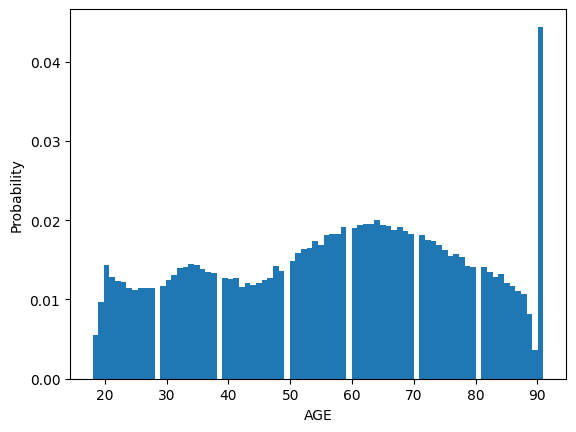

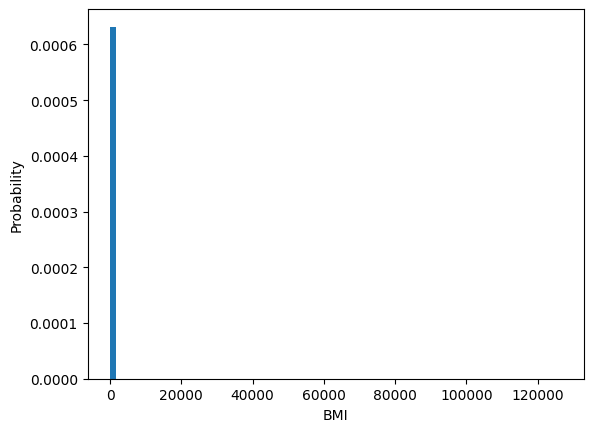

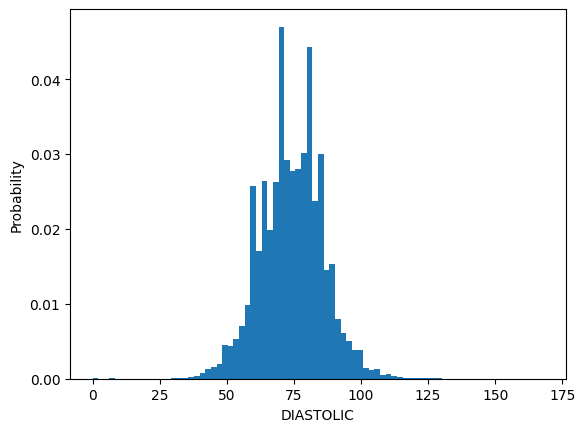

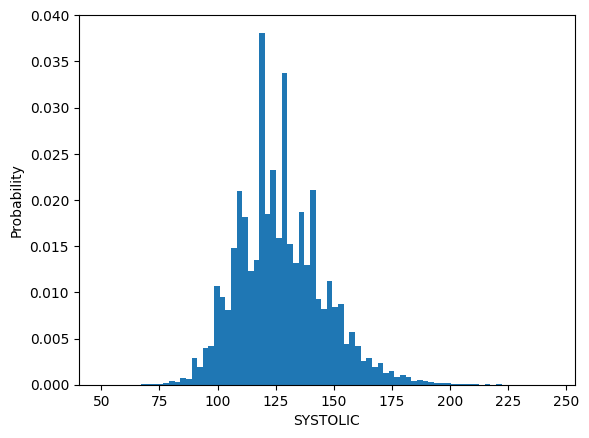

In [33]:
## Focus on non-binary features, here we check the distribution characteristics of AGE, BMI, DIASTOLIC, and SYSTOLIC columns.
cols = ['AGE', 'BMI', 'DIASTOLIC', 'SYSTOLIC']
for col_name in cols:
    col_data = list(patient_concept_mat_df[col_name])
    print(col_name)
    print('   min value: ', np.nanmin(col_data), ' max value: ', np.nanmax(col_data), ' mean value: ', np.nanmean(col_data), ' median value: ', np.nanmedian(col_data))

for i in range(len(cols)):
    plt.hist(list(patient_concept_mat_df[cols[i]]), density=True, bins=80)
    plt.ylabel('Probability')
    plt.xlabel(cols[i])
    plt.show()
    

Num of patients with BMI > 60: 387
Num of patients with BMI < 10: 125
Num of patients with DIASTOLIC pressure < 30: 77
No BP violations.


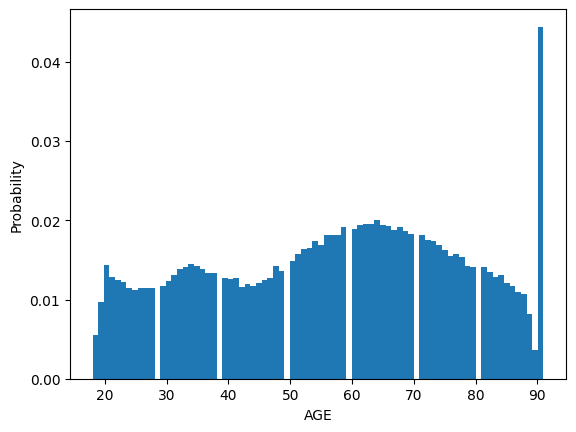

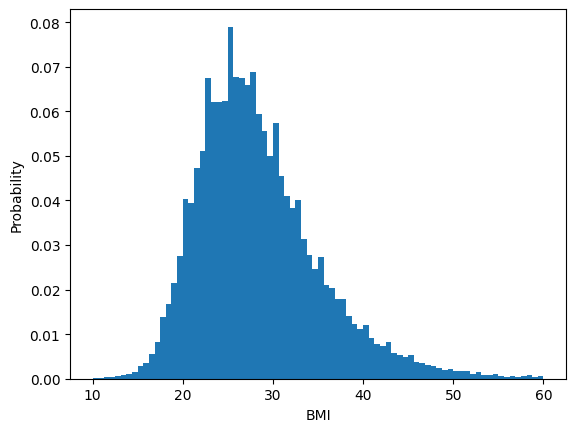

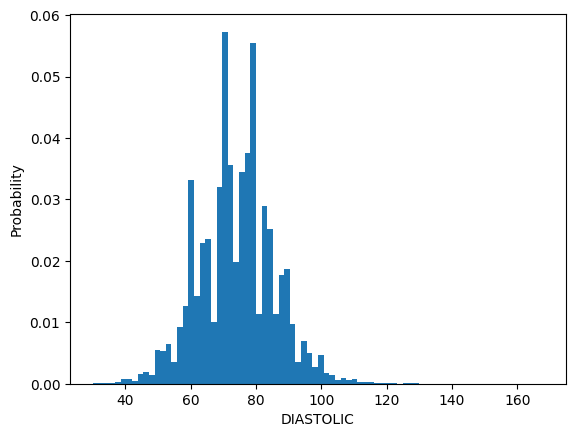

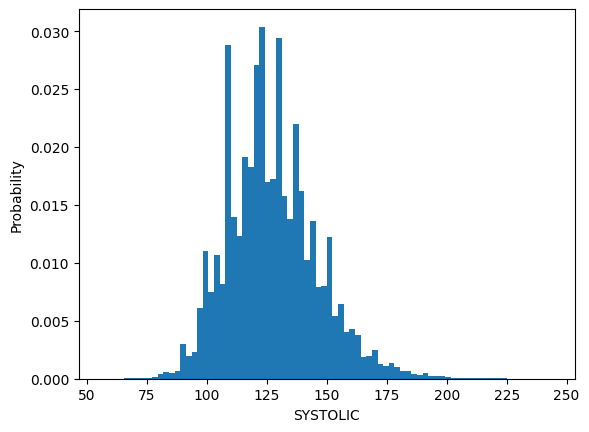

In [34]:
## Process outliers

# AGE: looks normal except that there are ~7 thousand patients with age 91 because of the age procedure for privacy protection (age >=91 --> 91).

# BMI: the max value is not reasonable --> correspond to an outlier. We remove patients with BMI > 60 or BMI < 10.
print('Num of patients with BMI > 60: %d' % np.sum((patient_concept_mat_df['BMI']) > 60))
print('Num of patients with BMI < 10: %d' % np.sum((patient_concept_mat_df['BMI']) < 10))
patient_concept_mat_df.drop(patient_concept_mat_df[patient_concept_mat_df['BMI'] > 60].index, inplace = True)
patient_concept_mat_df.drop(patient_concept_mat_df[patient_concept_mat_df['BMI'] < 10].index, inplace = True)

# DIASTOLIC: the max value is reasonable but the min value isn't --> correspond to an outlier. We remove patients with Diastolic pressure > 30.
print('Num of patients with DIASTOLIC pressure < 30: %d' % np.sum((patient_concept_mat_df['DIASTOLIC']) < 30))
patient_concept_mat_df.drop(patient_concept_mat_df[patient_concept_mat_df['DIASTOLIC'] < 30].index, inplace = True)

# SYSTOLIC: the min/max value is reasonable given the cohort was admitted to ICU/ED.

patient_concept_mat_df = patient_concept_mat_df.reset_index(drop=True)

# if DIASTOLIC > SYSTOLIC, remove the patient.
dias_bp_list = list(patient_concept_mat_df['DIASTOLIC'])
syst_bp_list = list(patient_concept_mat_df['DIASTOLIC'])
remove_row_index_list = []
for i in range(len(dias_bp_list)):
    dias_bp = dias_bp_list[i]
    syst_bp = syst_bp_list[i]
    if dias_bp != dias_bp and syst_bp != syst_bp and dias_bp >= syst_bp:
        remove_row_index_list.append(i)
if len(remove_row_index_list) > 0:
    patient_concept_mat_df.drop(remove_row_index_list, inplace = True)
    print("%d patients with wrong BP relationship removed." % len(remove_row_index_list))
else:
    print("No BP violations.")


for i in range(len(cols)):
    plt.hist(list(patient_concept_mat_df[cols[i]]), density=True, bins=80)
    plt.ylabel('Probability')
    plt.xlabel(cols[i])
    plt.show()
    

2. Handle missing values

{'AGE': np.float64(0.0), 'BMI': np.float64(0.43544811119638444), 'DIASTOLIC': np.float64(0.42726661171276165), 'SYSTOLIC': np.float64(0.42726661171276165)}


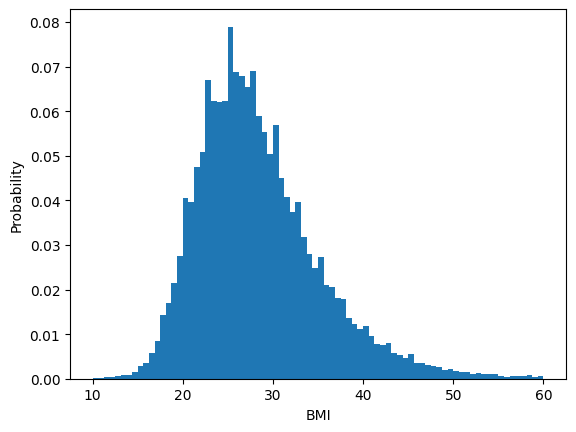

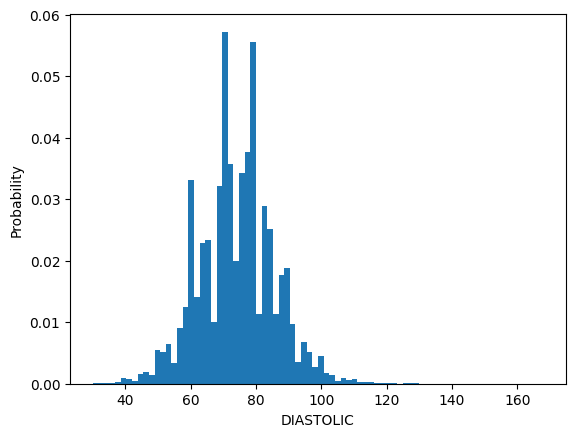

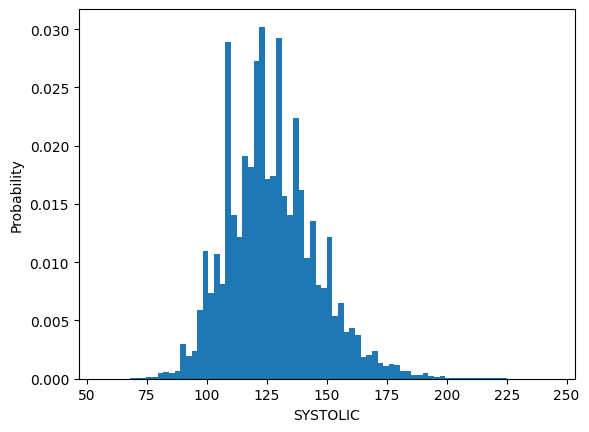

In [35]:
## Focus on non-binary features, here we check AGE, BMI, DIASTOLIC, and SYSTOLIC columns.
# Check column-wise missing rate
missing_ratio = {}
for col_name in cols:
    missing_ratio[col_name] = patient_concept_mat_df[col_name].isna().sum() / len(patient_concept_mat_df)   
print(missing_ratio)

# Determine missing value imputation strategy. 
# Since the missing rate for the three measures are high, one may choose to remove these columns.
# In this demo, we apply a naive sampling strategy to impute missing data. One can also learn a ML model to predict the measures.
cols = [col_name for col_name in cols if missing_ratio[col_name] > 0]
random.seed(4)
for col_name in cols:
    missing_num = patient_concept_mat_df[col_name].isna().sum()
    col_values = list(patient_concept_mat_df[col_name])
    sampling_list = [x for x in col_values if np.isnan(x) == False]
    for i in range(len(col_values)):
        if np.isnan(col_values[i]) == True:
            col_values[i] = random.choices(sampling_list)[0]

    patient_concept_mat_df[col_name] = col_values
    
for i in range(len(cols)):
    plt.hist(list(patient_concept_mat_df[cols[i]]), density=True, bins=80)
    plt.ylabel('Probability')
    plt.xlabel(cols[i])
    plt.show()

3. Normalize continuous columns

In [36]:
## Normalize the continuous feature in to [0,1]
# Store min max values for each related feature
min_max_log = {}
cols = ['AGE', 'BMI', 'DIASTOLIC', 'SYSTOLIC']
for col_name in cols:
    col_value = np.array(patient_concept_mat_df[col_name])
    min_max_log[col_name] = [np.min(col_value), np.max(col_value)]
    norm_col_value = (col_value - min_max_log[col_name][0]) / (min_max_log[col_name][1] - min_max_log[col_name][0])
    patient_concept_mat_df[col_name] = list(norm_col_value)
print(min_max_log)
np.save(save_folder_name + '/min_max_log.npy', min_max_log)

{'AGE': [np.int64(18), np.int64(91)], 'BMI': [np.float64(10.0), np.float64(60.0)], 'DIASTOLIC': [np.float64(30.0), np.float64(168.0)], 'SYSTOLIC': [np.float64(56.0), np.float64(244.0)]}


4. Remove extremely rare features

In [37]:
## Remove the binary columns with less than x 1s.
cols = list(patient_concept_mat_df.columns)
cols.remove('AGE')
cols.remove('BMI')
cols.remove('DIASTOLIC')
cols.remove('SYSTOLIC')
col_to_remove = []
for col_name in cols:
    col_value = np.array(patient_concept_mat_df[col_name])
    if np.sum(col_value)/len(col_value) < 0.00005:
        col_to_remove.append(col_name)
for col_name in col_to_remove:
    cols.remove(col_name)
    
cols = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'UN', 'OTHER', 'DIE_1y', 'GENDER'] + cols[8:]

patient_concept_mat_df_ = patient_concept_mat_df[cols + ['AGE','BMI','DIASTOLIC','SYSTOLIC']]
patient_concept_mat_df_.to_csv(save_folder_name + '/preprocessed_training_data.csv', index=False)

In [ ]:
# patient_concept_mat_df_

In [38]:
print(np.sum(patient_concept_mat_df_['WHITE']))
print(np.sum(patient_concept_mat_df_['BLACK']))
print(np.sum(patient_concept_mat_df_['ASIAN']))
print(np.sum(patient_concept_mat_df_['HISPANIC']))
print(np.sum(patient_concept_mat_df_['UN']))
print(np.sum(patient_concept_mat_df_['OTHER']))

140567
27575
9302
11652
10056
11934


In [39]:
all_data = patient_concept_mat_df_.values
np.random.seed(0)
np.random.shuffle(all_data)
training_data = all_data[:int(len(all_data)*0.7)]
testing_data = all_data[int(len(all_data)*0.7):]
training_data_df = pd.DataFrame(data=training_data, columns=list(patient_concept_mat_df_.columns))
testing_data_df = pd.DataFrame(data=testing_data, columns=list(patient_concept_mat_df_.columns))
print(np.sum(training_data_df['DIE_1y'])/len(training_data_df))
print(np.sum(testing_data_df['DIE_1y'])/len(testing_data_df))

training_data_df.to_csv(save_folder_name + '/normalized_training_data.csv', index=False)
testing_data_df.to_csv(save_folder_name + '/normalized_testing_data.csv', index=False)

min_max_log = np.load(save_folder_name + '/min_max_log.npy', allow_pickle=True).item()
for key, min_max in min_max_log.items():
    min_, max_ = min_max[0], min_max[1]
    col_values = np.array(training_data_df[key])
    training_data_df[key] = (1 - col_values)*min_ + col_values*max_
    col_values = np.array(testing_data_df[key])
    testing_data_df[key] = (1 - col_values)*min_ + col_values*max_
    
training_data_df.to_csv(save_folder_name + '/original_training_data.csv', index=False)
testing_data_df.to_csv(save_folder_name + '/original_testing_data.csv', index=False)

0.11938278289117488
0.11642927075766668


In [3]:
df = pd.read_csv("/u/student/2024/cs24btnsr11002/2.0/saved_dataset/original_training_data.csv")
df.head()

,WHITE,BLACK,ASIAN,HISPANIC,UN,OTHER,DIE_1y,GENDER,008,008.5,...,985,987,988,989,990,994,AGE,BMI,DIASTOLIC,SYSTOLIC
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,77.0,19.4,74.0,156.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,73.0,26.3,66.0,131.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.0,21.1,65.0,140.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,65.0,21.2,88.0,105.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,45.0,24.2,65.0,98.0


In [6]:
print(df.shape[1])

1498
